# What is the L1 Cache throughput depending on pattern?

The maximum bandwidth of the L1 cache is 128B per Cycle. However, this depends highly on the address patterns of loads. 

In [1]:
import pycuda.driver as drv
import pycuda
import pycuda.autoinit
import numpy
import matplotlib.pyplot as plt
from subprocess import run, PIPE
from pycuda.compiler import SourceModule

In [2]:
A_gpu = drv.mem_alloc(1024*1024)
B_gpu = drv.mem_alloc(1024*1024)

In [3]:
def buildKernel(kernel_text, kernel_name):
    mod = SourceModule(kernel_text, arch="sm_70", options=["-lineinfo" "-O3" "-w" "-std=c++11"])
    function = mod.get_function(kernel_name)
    function.prepare((numpy.int64, 'P', 'P', numpy.float64))
    return function

def timeKernel(function, block, grid):
    start = drv.Event()
    end = drv.Event()

    start.record()
    function.prepared_call(grid, block, 10000, A_gpu, B_gpu, 0)
    end.record()
    end.synchronize()
    return end.time_since(start)

def printSASS(code):
    cubin = pycuda.compiler.compile(code, options=["-w", "-std=c++11"], arch="sm_70")

    run(["echo \"" + code + "\" >> temp.cubin"], stdout=PIPE, shell=True)

    newFile = open("temp.cusbin", "wb")
    newFile.write(cubin)
    newFile.close()

    result = run(["nvdisasm  temp.cusbin"], stdout=PIPE, shell=True)

    print(len(result.stdout.decode("utf-8").split("\n")))

    print(result.stdout.decode("utf-8"))

    newFile = open("temp.disasm", "wb")
    newFile.write(result.stdout)
    newFile.close()

    

In [4]:
kernel_string = """
__global__  void __launch_bounds__(1024, 1) kernel(int iters, double *A, double *B, int zero) {{

  double sum = 0.0;

  double *dA = A + (threadIdx.x % 32){2};
  double *dB = B + (threadIdx.x % 32){2};

#pragma unroll(1)
  for (int iter = 0; iter < iters; iter++) {{
  #pragma unroll({1})
    for (int n = 0; n < {0}; n++) {{
        sum += dA[n * 32 * zero] * dB[n * 32 *zero];
    }}
    if (sum == -12.3) {{
        A[threadIdx.x] = sum;
    }}

  }}

}}"""



In [5]:
def measureSpread(spread):
    text = kernel_string.format(128, 64, spread)
    function = buildKernel(text, "kernel")

    times = [timeKernel(function, (256, 1, 1), (1, 1, 1)) for i in range(11)]
    times.sort()
    dt = times[0]
    return (dt / (10000 * 128 * 8 * 2) / 1000 * 1.38 * 1000000000)


##  All threads single Address

The last argument " / 32" applies a scaling factor to the thread addresses. Dividing by 32 makes all threads load the same address 

In [6]:
print(measureSpread("/ 32"))

2.023582376539707


A result of 2 cycles per load indicates that even though all lanes load the same address, each load takes at least 2 cycles.

## Spreads

By introducing a factor "*x", addresses are spread out.

In [7]:
data = []
for i in range(1, 65):
    data.append(measureSpread("*" + str(i)))
    print(data[-1])

2.022771656513214
3.9868954047560696
2.9990613274276257
7.967244386672974
3.9896704629063597
5.979236014187335
4.984165348112583
15.923156172037123
5.9833307415246955
5.983468517661094
6.972053423523902
11.943938702344893
7.966556534171104
7.966675288975238
8.961247801780699
31.836838692426674
8.961593270301819
10.949683383107184
11.94431810081005
13.933897018432615
11.944210141897202
10.950211867690086
13.93428875505924
20.89456129074096
14.92707172036171
13.934366896748543
10.94951270520687
16.916191041469574
10.949784144759178
8.961640566587448
10.95020467042923
31.83679550886154
7.966612569987773
8.961478114128113
13.933667734265327
14.928091675043104
10.949840694665907
17.910786688327786
12.938948705792425
22.884799271821972
14.927839770913126
16.916203379631042
10.94958673417568
19.90003144741058
17.91088333725929
16.916216745972633
16.917364194989204
31.834887206554406
15.924419805407524
18.906509220600128
11.944290339946747
17.911849826574322
20.89533242583275
14.92829422652721

<BarContainer object of 64 artists>

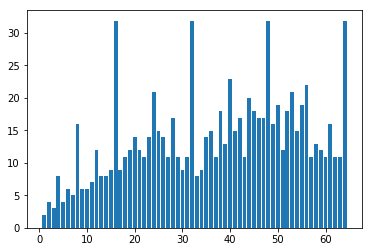

In [11]:
plt.bar(range(1, len(data)+1), data)

In [10]:
printSASS(kernel_string.format(64, 16, "*3"))

330
	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM70 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM70)"
	.elftype	@"ET_EXEC"


//--------------------- .debug_frame              --------------------------
	.section	.debug_frame,"",@progbits
.debug_frame:
        /*0000*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff
        /*0010*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x03, 0x00, 0x04, 0x7c, 0xff, 0xff, 0xff, 0xff, 0x0f, 0x0c, 0x81, 0x80
        /*0020*/ 	.byte	0x80, 0x28, 0x00, 0x08, 0xff, 0x81, 0x80, 0x28, 0x08, 0x81, 0x80, 0x80, 0x28, 0x00, 0x00, 0x00
        /*0030*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0040*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0048*/ 	.dword	kernel
        /*0050*/ 	.byte	0x70, 0x07, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x02, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00
        /*0060*/ 	.byte	0x00, 0x00, 0x0